In [36]:
import json
import os

import pprint
import matplotlib.pyplot as plt
from   merlion.evaluate.forecast import ForecastMetric
from   merlion.models.ensemble.combine import Mean, ModelSelector
from   merlion.models.ensemble.forecast import (ForecasterEnsemble, 
                                                ForecasterEnsembleConfig)
from   merlion.models.factory import ModelFactory
from   merlion.models.forecast.arima import Arima, ArimaConfig
from   merlion.models.forecast.prophet import Prophet, ProphetConfig
from   merlion.models.forecast.smoother import MSES, MSESConfig
from   merlion.transform.base import Identity
from   merlion.transform.resample import TemporalResample
from   merlion.utils.time_series import TimeSeries as TS
import numpy as np
from   ts_datasets.forecast import M4

In [2]:
ts, meta = M4(subset='Hourly')[5]
trainval = meta['trainval']

100%|██████████| 414/414 [00:00<00:00, 790.40it/s]


In [3]:
ts.head()

,H6
1970-01-01 00:00:00,5780.0
1970-01-01 01:00:00,5497.0
1970-01-01 02:00:00,5306.0
1970-01-01 03:00:00,5178.0
1970-01-01 04:00:00,5235.0


In [4]:
meta.head()

,trainval
1970-01-01 00:00:00,True
1970-01-01 01:00:00,True
1970-01-01 02:00:00,True
1970-01-01 03:00:00,True
1970-01-01 04:00:00,True


In [5]:
meta.trainval.value_counts()

True     700
False     48
Name: trainval, dtype: int64

In [6]:
deltas = np.diff(ts.index)
print(f'Has missing data: {any(deltas != deltas[0])}')

Has missing data: False


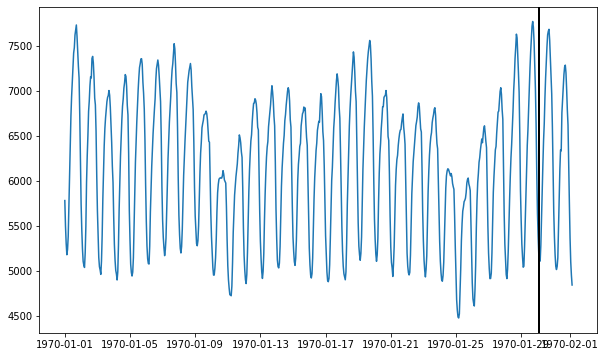

In [7]:
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(111)
ax.plot(ts)
ax.axvline(ts[trainval].index[-1], c='k', lw=2);

In [8]:
train = TS.from_pd(ts[trainval])
test = TS.from_pd(ts[-trainval])

### Model Init
Models included here:
- ARIMA
- Prophet (Facebook forecasting model)
- MSES (Multi-Scale Exponential Smoothing; Salesforce model)

In [9]:
config1 = ArimaConfig(max_forecast_steps=100, 
                      order=(20, 1, 5), 
                      transform=TemporalResample(granularity='1h'))
mod1 = Arima(config1)

config2 = ProphetConfig(max_forecast_steps=100, transform=Identity())
mod2 = Prophet(config2)

config3 = MSESConfig(max_forecast_steps=100, 
                     max_backstep=60, 
                     transform=TemporalResample(granularity='1h'))
mod3 = MSES(config3)

Evaluation metric: sMAPE (symmetric Mean Average Precision Error):
sMAPE(y, yhat) = (200/T)∑(|yhat[t] - y[t]| / (|yhat[t]| + |y[t]|))
.....where t = 1, 2, ..., T

In [10]:
# The ForecasterEnsemble is a forecaster, and we treat it as a first-class 
# model.
# Its config takes a combiner object, specifying how you want to combine
# the predictions of individual models in the ensemble. There are two ways 
# to specify the actual models in the ensemble, which we cover below.

# The first way to specify the models in the ensemble is to provide their
# individual configs when initializing the ForecasterEnsembleConfig. Note
# that if using this syntax, you must also provide the names of the model
# classes.
#
# The combiner here will simply take the mean prediction of the ensembles
# here
ensemble_config = ForecasterEnsembleConfig(
    combiner=Mean(),
    model_configs=[(type(mod1).__name__, config1),
                   (type(mod2).__name__, config2),
                   (type(mod3).__name__, config3)])
ensemble = ForecasterEnsemble(config=ensemble_config)

In [11]:
# Alternatively, you can skip giving the individual model configs to the
# ForecasterEnsembleConfig, and instead directly specify the models when
# initializing the ForecasterEnsemble itself.
#
# The combiner here uses the sMAPE to compare individual models, and
# selects the model with the lowest sMAPE
selector_config = ForecasterEnsembleConfig(
    combiner=ModelSelector(metric=ForecastMetric.sMAPE))
selector = ForecasterEnsemble(
    config=selector_config, models=[mod1, mod2, mod3])

### Model Training

In [23]:
print(f'Training {type(mod1).__name__}...')
forecast1, se1 = mod1.train(train)
#print('se:', se1.mean())

print(f'\nTraining {type(mod2).__name__}...')
forecast2, se2 = mod2.train(train)
#print('se:', se2.mean())

print(f'\nTraining {type(mod3).__name__}...')
forecast3, se3 = mod3.train(train)
#print('se:', se3.mean())

print('\nTraining ensemble...')
forecastE, seE = ensemble.train(train)
#print('se:', seE.mean())

print('\nTraining model selector...')
forecastS, seS = selector.train(train)
#print('se:', seS.mean())

print('Done!')

Training Arima...


INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Training Prophet...

Training MSES...


INFO:merlion.models.ensemble.forecast:Training model 1/3...



Training ensemble...


INFO:merlion.models.ensemble.forecast:Training model 2/3...
INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3...
INFO:merlion.models.ensemble.forecast:Training model 1/3...



Training model selector...


INFO:merlion.models.ensemble.forecast:Training model 2/3...
INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Training model 3/3...
INFO:merlion.models.ensemble.forecast:Evaluating validation performance...
Validation: 100%|██████████| 500400/500400 [00:01<00:00, 481039.62it/s] 
INFO:merlion.models.ensemble.forecast:Re-training model 1/3 on full data...
INFO:merlion.models.ensemble.forecast:Re-training model 2/3 on full data...
INFO:merlion.models.forecast.prophet:Add seasonality 24
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:merlion.models.ensemble.forecast:Re-training model 3/3 on full data...


Done!


### Model Inference

In [24]:
# Truncate the test data to ensure that we are within each model's maximum
# forecast horizon.
sub_test = test[:50]
time_stamps = sub_test.univariates[sub_test.names[0]].time_stamps

In [25]:
# Get the forecast & standard error of each model. These are both
# merlion.utils.TimeSeries objects. Note that the standard error is None 
# for models which don't support uncertainty estimation (like MSES and all
# ensembles).
forecast1, se1 = mod1.forecast(time_stamps=time_stamps)
forecast2, se2 = mod2.forecast(time_stamps=time_stamps)

# You may optionally specify a time series prefix as context. If one isn't
# specified, the prefix is assumed to be the training data. Here, we just 
# make this dependence explicit. More generally, this feature is useful if
# you want to use a pre-trained model to make predictions on data further
# in the future from the last time it was trained.
forecast3, se3 = mod3.forecast(time_stamps=time_stamps, 
                               time_series_prev=train)

# The same options are available for ensembles as well, though the stderr
# is None
forecastE, seE = ensemble.forecast(time_stamps=time_stamps)
forecastS, seS = selector.forecast(time_stamps=time_stamps, 
                                   time_series_prev=train)

### Mod Vis and Eval

sMAPE: 3.823


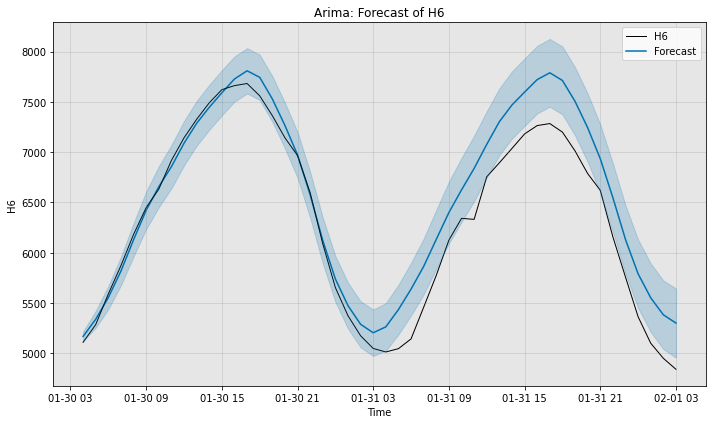

In [29]:
smape1 = ForecastMetric.sMAPE.value(ground_truth=sub_test, 
                                    predict=forecast1)
print(f'sMAPE: {smape1:.3f}')
fig, ax = mod1.plot_forecast(time_series=sub_test, 
                             plot_forecast_uncertainty=True)

sMAPE: 2.912


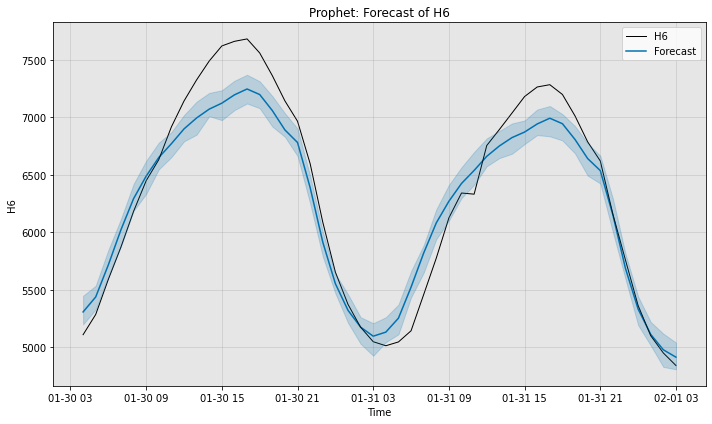

In [30]:
smape2 = ForecastMetric.sMAPE.value(ground_truth=sub_test, 
                                    predict=forecast2)
print(f'sMAPE: {smape2:.3f}')
fig, ax = mod2.plot_forecast(time_series=sub_test,
                             time_series_prev=train,
                             plot_forecast_uncertainty=True)

sMAPE: 4.377


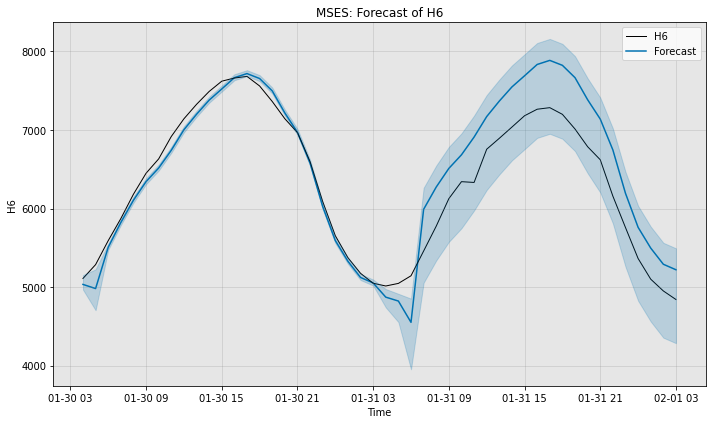

In [31]:
smape3 = ForecastMetric.sMAPE.value(ground_truth=sub_test, 
                                    predict=forecast3)
print(f'sMAPE: {smape3:.3f}')
fig, ax = mod3.plot_forecast(time_series=sub_test, 
                             plot_forecast_uncertainty=True)

sMAPE: 2.604


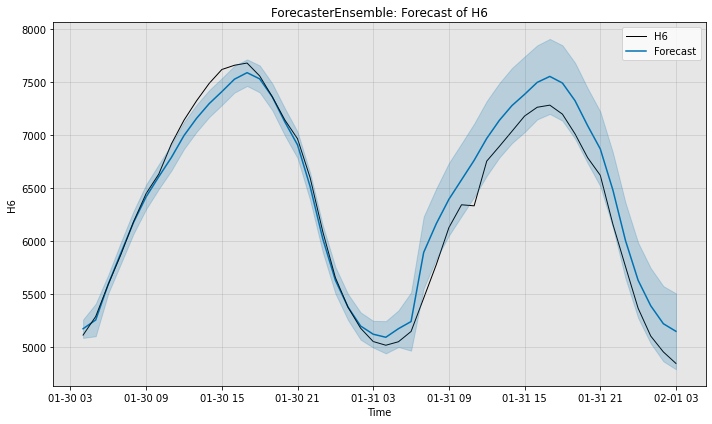

In [34]:
smapeE = ForecastMetric.sMAPE.value(ground_truth=sub_test, 
                                    predict=forecastE)
print(f'sMAPE: {smapeE:.3f}')
fig, ax = ensemble.plot_forecast(time_series=sub_test, 
                                 plot_forecast_uncertainty=True)

sMAPE: 3.823


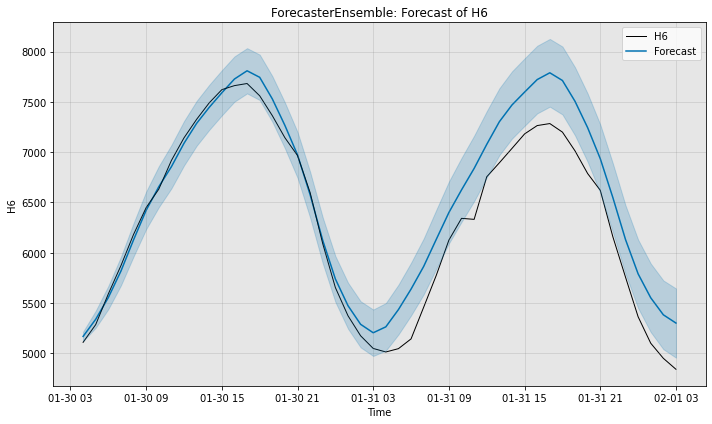

In [35]:
smapeS = ForecastMetric.sMAPE.value(ground_truth=sub_test, 
                                    predict=forecastS)
print(f'sMAPE: {smapeS:.3f}')
fig, ax = selector.plot_forecast(time_series=sub_test, 
                                 plot_forecast_uncertainty=True)

### Saving/Loading

In [37]:
os.makedirs('models', exist_ok=True)
path = os.path.join('models', 'prophet')
mod2.save(path)

In [ ]:
pp = pprint.PrettyPrintet()
with open(os.path.join(path. 'config.json')) as f:
    print(f'{type(mod2).__name__} Config)